# Project 4 - Matt Sloan

## Introduce the problem
Introduce the project. What is the problem you are trying to solve? What questions are you trying to find answer

https://www.kaggle.com/datasets/cisautomotiveapi/large-car-dataset/download?datasetVersionNumber=4 (warning: large file)   
from 
https://www.kaggle.com/datasets/cisautomotiveapi/large-car-dataset
## Create ipynb template for website -darkmode html command, set low jpg, ignore warnings, default imports numpy pandas traintest

I'm looking to see if there are specific specific features that tend to make vehicles more fuel efficient. We all know that having a smaller engine inherently means higher mpg's... or does it?
What other factors tend to be at play here? Does one manufacturer tend to specialize in this? Bonus... what cars tend to have the best price/mpg ratio?

## What is clustering and how does it work?
Explain what clustering is and how it works (e.g., k-means and/or agglomerative that we have gone over in class)

## TODO

## Introduce the data
Where did you find it? What is the data about (include links)? What are the features (with additional explanations if not already self-explanatory from the name itself)?

I was looking for mpg data for vehicles that was also paired with msrp. I decided to use the [dataset from fueleconomy.gov](https://fueleconomy.gov/feg/download.shtml) for mpg values and [this... 5gb dataset from kaggle.](https://www.kaggle.com/datasets/cisautomotiveapi/large-car-dataset) for vehicle info.   
It appears to be a sample of AutoDealerData.com of vehicle listings from Illinois from June 2018 until 2020.   
I will probably remove duplicates in an attempt to save my RAM from annihilation.   
This dataset has 156 features and ~5.7 million entries.
The features that I am most interested in are:   
* msrp
* brandName
* modelName
* bodyClass
* DisplacementCC
* Doors
* DriveType
* EngineCylcinders
* EngineManufacturer
* MakeID
* Manufacturer
* Model
* ModelYear
* Turbo
* TransissionSpeeds
* TransmissionStyle   
However I will be utilizing most of the remaining features as well.   
---
   
And from the fueleconomy.gov dataset, I will be using:
* comb08 - combined MPG from fueltype 1 (I will be assuming the primary fuel type is normally used)
* make - manufacturer (division)
* mfrCode - 3-character manufacturer code
* model - model name (carline)
* year - model year
* displ - engine displacement in liters   
   
I intend to use these variables to accurately append the combined mpg to the vehicle

## Data Understanding/Visualization
Use methods to try to further understand and visualize the data. Make sure to remember your initial problems/questions when completing this step.
While exploring, does anything else stand out to you (perhaps any surprising insights?)

**How does this step relate to your modeling?**

Let us start out by loading the file.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='jpg'
sns.set(rc={"figure.figsize":(10, 10)})
sns.set(rc={"figure.dpi": 75})

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# these are the columns we need to keep
keeping_colms = ['brandName',
            'modelName',
            'vf_BodyClass',
            'vf_FuelInjectionType',
            'vf_Manufacturer',
            'vf_PlantCity',
            'vf_PlantCompanyName',
            'vf_PlantCountry',
            'vf_PlantState',
            'vf_Series',
            'vf_Series2',
            'vf_TransmissionSpeeds',
            'vf_TransmissionStyle',
            'vf_Trim',
            'vf_Trim2',
            'vf_Turbo',
            'msrp',
            'askPrice',
            'mileage',
            'isNew',
            'vf_CurbWeightLB',
            'vf_DisplacementL',
            'vf_Doors',
            'vf_ManufacturerId',
            'vf_ModelID',
            'vf_ModelYear'
       ]

# main working df
main_df = pd.DataFrame()

# temp df for mpg data
mpg_df = pd.DataFrame()

# our current working df
main_df = pd.read_csv('data/archive/CIS_Automotive_Kaggle_Sample.csv',
                            engine='c',
                            usecols=keeping_colms,
                            #nrows=100000,
                            header=0,
                            dtype = {
                                'msrp': pd.Int64Dtype(),
                                'askPrice': pd.Int64Dtype(),
                                'mileage' : pd.Int64Dtype(),
                                'isNew' : bool,
                                'vf_CurbWeightLB' : pd.Int64Dtype(),
                                'vf_DisplacementL' : np.float32,
                                'vf_ManufacturerId' : pd.Int64Dtype(),
                                'vf_ModelID' : pd.Int64Dtype(),
                                'vf_Doors' :  pd.Int64Dtype(),
                                'vf_ModelYear' : pd.Int64Dtype(),
                                    } # end read_csv dtype
                     ) # end read_csv

mpg_df = pd.read_csv('data/archive/vehicles.csv',
                            usecols= ['comb08',
                                  'make',
                                  'mfrCode',
                                  'model',
                                  'year',
                                  'displ'
                                     ],
                            header=0,
                            dtype = {'comb08': np.float32,
                                  'make': pd.CategoricalDtype(),
                                  'year': pd.Int32Dtype(),
                                  'displ': np.float32
                                    } # end read_csv dtype
                     ) # end read_csv

C:\Users\Matt\mambaforge\envs\DataMining\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (144) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Matt\mambaforge\envs\DataMining\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (73) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


I was having a lot of issues setting the dtype while reading the csv file because of NA values. Unlike Numpy, Pandas int32 dtype supports NA values!   

>This is Matt from a few hours after trying this. I've decied that 3 million rows is plenty. Who could want like 64gb of RAM anways?   
>   
>...definitely not me

In [3]:
main_df.head()

,msrp,askPrice,mileage,isNew,brandName,modelName,vf_BodyClass,vf_CurbWeightLB,vf_DisplacementL,vf_Doors,vf_FuelInjectionType,vf_Manufacturer,vf_ManufacturerId,vf_ModelID,vf_ModelYear,vf_PlantCity,vf_PlantCompanyName,vf_PlantCountry,vf_PlantState,vf_Series,vf_Series2,vf_TransmissionSpeeds,vf_TransmissionStyle,vf_Trim,vf_Trim2,vf_Turbo
0,1498,1498,0,False,MITSUBISHI,Eclipse Spyder,Convertible/Cabriolet,<NA>,3.0,2,Multipoint Fuel Injection (MPFI),MITSUBISHI MOTORS NORTH AMERICA,1054,2321,2002,BLOOMINGTON-NORMAL,NaN,UNITED STATES (USA),ILLINOIS,SPORTS,NaN,NaN,NaN,NaN,NaN,NaN
1,10589,10589,0,False,NISSAN,Altima,Sedan/Saloon,<NA>,2.5,4,NaN,NISSAN NORTH AMERICA INC,997,1904,2016,CANTON,Nissan North America Inc.,UNITED STATES (USA),MISSISSIPPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11992,9940,0,False,FORD,Escape,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,<NA>,1.6,4,Stoichiometric gasoline direct injection (SGDI),FORD MOTOR COMPANY USA,976,1798,2014,LOUISVILLE,Louisville Assembly,UNITED STATES (USA),KENTUCKY,SE,NaN,NaN,NaN,NaN,NaN,NaN
3,12387,12387,0,False,CHEVROLET,Cruze,Sedan/Saloon,<NA>,1.4,4,NaN,GENERAL MOTORS LLC,984,1832,2017,LORDSTOWN,GMNA,UNITED STATES (USA),OHIO,Premier,NaN,NaN,Automatic,NaN,NaN,Yes
4,41659,41659,0,True,FORD,F-150,Pickup,<NA>,5.0,<NA>,NaN,FORD MOTOR COMPANY USA,976,1801,2019,DEARBORN,Dearborn,UNITED STATES (USA),MICHIGAN,NaN,NaN,NaN,Automatic,NaN,NaN,NaN


In [4]:
mpg_df.head()

,comb08,displ,make,model,year,mfrCode
0,21.0,2.0,Alfa Romeo,Spider Veloce 2000,1985,NaN
1,11.0,4.9,Ferrari,Testarossa,1985,NaN
2,27.0,2.2,Dodge,Charger,1985,NaN
3,11.0,5.2,Dodge,B150/B250 Wagon 2WD,1985,NaN
4,19.0,2.2,Subaru,Legacy AWD Turbo,1993,NaN


In [5]:
main_df.describe()

,msrp,askPrice,mileage,vf_CurbWeightLB,vf_DisplacementL,vf_Doors,vf_ManufacturerId,vf_ModelID,vf_ModelYear,vf_TransmissionSpeeds
count,5.695015e+06,5.695015e+06,5.695015e+06,117190.000000,5.648866e+06,4.914214e+06,5.693755e+06,5.689172e+06,5.693733e+06,1.293522e+06
mean,7.445697e+05,1.869206e+05,2.241465e+04,4004.123679,3.314681e+00,4.021807e+00,1.207672e+03,3.716958e+03,2.015305e+03,6.894028e+00
std,3.926443e+07,1.876752e+07,9.010528e+05,584.108085,6.418559e+00,5.773043e-01,1.658599e+03,4.513855e+03,4.613182e+00,1.390092e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,2335.000000,0.000000e+00,2.000000e+00,9.550000e+02,1.684000e+03,1.980000e+03,1.000000e+00
25%,1.139600e+04,1.077700e+04,0.000000e+00,3485.000000,2.000000e+00,4.000000e+00,9.840000e+02,1.847000e+03,2.014000e+03,6.000000e+00
50%,2.255800e+04,2.056600e+04,0.000000e+00,4025.000000,2.500000e+00,4.000000e+00,9.930000e+02,1.945000e+03,2.017000e+03,6.000000e+00
75%,3.399500e+04,3.194500e+04,2.616100e+04,4330.000000,3.600000e+00,4.000000e+00,1.034000e+03,2.735000e+03,2.019000e+03,8.000000e+00
max,2.147484e+09,2.147484e+09,2.147484e+09,5815.000000,2.000000e+02,6.000000e+00,1.944800e+04,2.789700e+04,2.021000e+03,1.000000e+01


In [6]:
mpg_df.describe()

,comb08,displ,year
count,45777.000000,45313.000000,45777.000000
mean,21.290932,3.280372,2003.558031
std,9.637799,1.356619,12.165146
min,7.000000,0.000000,1984.000000
25%,17.000000,2.200000,1992.000000
50%,20.000000,3.000000,2005.000000
75%,23.000000,4.200000,2014.000000
max,142.000000,8.400000,2023.000000


Nulls?

In [7]:
print("---------------- main df ----------------")

for col in main_df.columns:
    if main_df[col].isnull().sum() > 0:
        print(f'{round(((main_df[col].isnull().sum()/main_df.shape[0])*100),2)}% -----{main_df[col].isnull().sum()} null values in {col}')
        
print("\n---------------- mpg df ----------------")

for col in mpg_df.columns:
    if mpg_df[col].isnull().sum() > 0:
        print(f'{round(((mpg_df[col].isnull().sum()/mpg_df.shape[0])*100),2)}% -----{mpg_df[col].isnull().sum()} null values in {col}')

---------------- main df ----------------
0.02% -----1260 null values in brandName
0.1% -----5843 null values in modelName
0.2% -----11559 null values in vf_BodyClass
97.94% -----5577825 null values in vf_CurbWeightLB
0.81% -----46149 null values in vf_DisplacementL
13.71% -----780801 null values in vf_Doors
75.4% -----4293878 null values in vf_FuelInjectionType
0.02% -----1260 null values in vf_Manufacturer
0.02% -----1260 null values in vf_ManufacturerId
0.1% -----5843 null values in vf_ModelID
0.02% -----1282 null values in vf_ModelYear
10.79% -----614448 null values in vf_PlantCity
27.54% -----1568615 null values in vf_PlantCompanyName
3.13% -----178494 null values in vf_PlantCountry
26.74% -----1522665 null values in vf_PlantState
24.66% -----1404200 null values in vf_Series
95.34% -----5429563 null values in vf_Series2
77.29% -----4401493 null values in vf_TransmissionSpeeds
66.21% -----3770877 null values in vf_TransmissionStyle
60.5% -----3445574 null values in vf_Trim
97.91% -

Collinearity?

<AxesSubplot:>

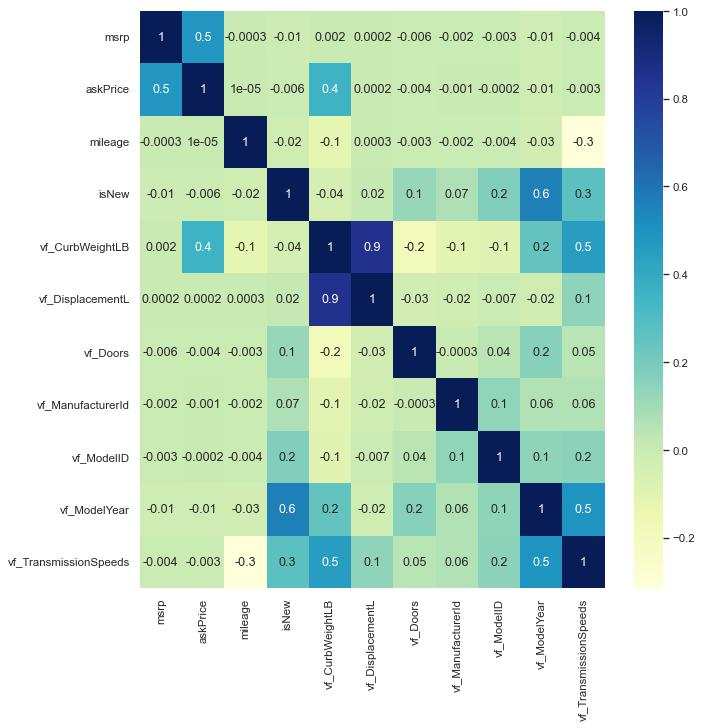

In [8]:
sns.heatmap(main_df.corr(), cmap="YlGnBu", annot=True, fmt='.1g')

<AxesSubplot:>

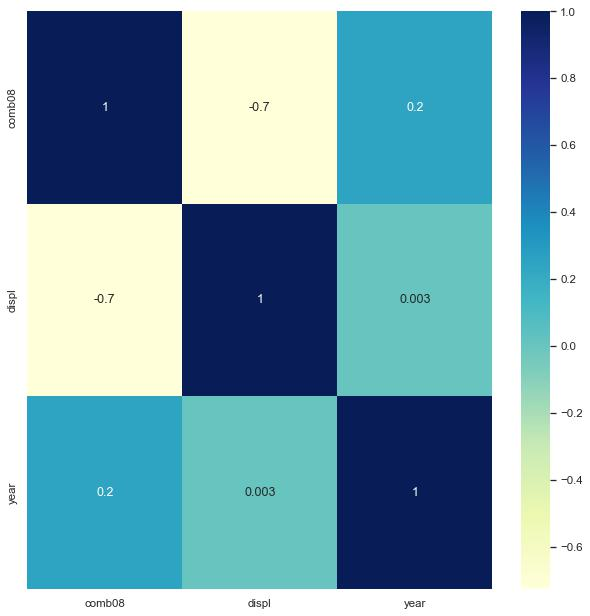

In [9]:
sns.heatmap(mpg_df.corr(), cmap="YlGnBu", annot=True, fmt='.1g')

## Pre-processing the data
What pre-processing steps do you follow? Explain why you do each pre-processing step.

First I want to remove colms with a large number of missing values. Let's remove columns missing 10% or more.

In [10]:
print("---------------- main df ----------------")

for col in main_df.columns:
    if main_df[col].isnull().sum()/main_df.shape[0] > 0.10:
        del main_df[col]
    else:
        print(f'{round(((main_df[col].isnull().sum()/main_df.shape[0])*100),2)}% -----{main_df[col].isnull().sum()} null values in {col}')
        
print("\n---------------- mpg df ----------------")

for col in mpg_df.columns:
    if mpg_df[col].isnull().sum()/mpg_df.shape[0] > 0.10:
        del mpg_df[col]
    else:
        print(f'{round(((mpg_df[col].isnull().sum()/mpg_df.shape[0])*100),2)}% -----{mpg_df[col].isnull().sum()} null values in {col}')

---------------- main df ----------------
0.0% -----0 null values in msrp
0.0% -----0 null values in askPrice
0.0% -----0 null values in mileage
0.0% -----0 null values in isNew
0.02% -----1260 null values in brandName
0.1% -----5843 null values in modelName
0.2% -----11559 null values in vf_BodyClass
0.81% -----46149 null values in vf_DisplacementL
0.02% -----1260 null values in vf_Manufacturer
0.02% -----1260 null values in vf_ManufacturerId
0.1% -----5843 null values in vf_ModelID
0.02% -----1282 null values in vf_ModelYear
3.13% -----178494 null values in vf_PlantCountry

---------------- mpg df ----------------
0.0% -----0 null values in comb08
1.01% -----464 null values in displ
0.0% -----0 null values in make
0.0% -----0 null values in model
0.0% -----0 null values in year


Now we'll rid of rows with missing values

In [11]:
main_original_size = main_df.shape
mpg_original_size = mpg_df.shape


main_df = main_df.dropna()
mpg_df = mpg_df.dropna()

In [12]:
print(f'main df shape: {main_df.shape} and main df is now {round(main_df.shape[0]/main_original_size[0],3)*100}% of the original size ({main_original_size}).')
print(f'mpg df shape: {mpg_df.shape} and mpg df is now {round(mpg_df.shape[0]/mpg_original_size[0],3)*100}% of the original size ({mpg_original_size}).')

main df shape: (5466424, 13) and main df is now 96.0% of the original size ((5695015, 13)).
mpg df shape: (45313, 5) and mpg df is now 99.0% of the original size ((45777, 5)).


Now since our goal is to classify vehicle features that are associated with higher mpg values, I will bin mpg into sets of 5 with higher values being higher mpg values

In [13]:
mpg_df['binned_mpg'] = mpg_df['comb08'].apply(lambda x: (5 * round(x/5))/5).astype(np.int32)

Time to add our mpg values to our main df.   
1) make sure brand name/manufacterur and model name are same case so we can match them
2) rename our mpg_df columns so that we can inner join

In [14]:
# set these column names to lowercase so it's easier to match (for me)
main_df['brandName'] = main_df['brandName'].str.lower()
main_df['modelName'] = main_df['modelName'].str.lower()

mpg_df['make'] = mpg_df['make'].str.lower()
mpg_df['model'] = mpg_df['model'].str.lower()

In [15]:
# rename the columns in the other df so they can match with the main df
mpg_df.rename(columns = {'year': 'vf_ModelYear', 'model': 'modelName', 'make': 'brandName', 'displ': 'vf_DisplacementL'}, inplace = True)

In [16]:
# shape of our old df?
main_df.shape

(5466424, 13)

In [17]:
# inner join (merge) by default - our matching columns will be our 'lock and key' to make sure our 'other' column(s) get combined
comb_df = main_df.merge(mpg_df)

In [18]:
del main_df
del mpg_df

In [19]:
# shape of our new df?
comb_df.shape

(2799680, 15)

In [20]:
comb_df.head()

,msrp,askPrice,mileage,isNew,brandName,modelName,vf_BodyClass,vf_DisplacementL,vf_Manufacturer,vf_ManufacturerId,vf_ModelID,vf_ModelYear,vf_PlantCountry,comb08,binned_mpg
0,1498,1498,0,False,mitsubishi,eclipse spyder,Convertible/Cabriolet,3.0,MITSUBISHI MOTORS NORTH AMERICA,1054,2321,2002,UNITED STATES (USA),21.0,4
1,1498,1498,0,False,mitsubishi,eclipse spyder,Convertible/Cabriolet,3.0,MITSUBISHI MOTORS NORTH AMERICA,1054,2321,2002,UNITED STATES (USA),20.0,4
2,1498,1498,0,False,mitsubishi,eclipse spyder,Convertible/Cabriolet,3.0,MITSUBISHI MOTORS NORTH AMERICA,1054,2321,2002,UNITED STATES (USA),21.0,4
3,1498,1498,0,False,mitsubishi,eclipse spyder,Convertible/Cabriolet,3.0,MITSUBISHI MOTORS NORTH AMERICA,1054,2321,2002,UNITED STATES (USA),20.0,4
4,1998,1498,0,False,mitsubishi,eclipse spyder,Convertible/Cabriolet,3.0,MITSUBISHI MOTORS NORTH AMERICA,1054,2321,2002,UNITED STATES (USA),21.0,4


In [21]:
# a little bit of code that lists all of the models for each manufacturer in our dataset :)

# for make in comb_df['brandName'].unique():
#     print(make, comb_df.loc[comb_df['brandName'] == make]['modelName'].unique(), '\n')

## Modeling (Clustering)
What model(s) do you use to try to solve your problem? Why do you choose those model(s)?

I will use random forests to predict mpg of a vechile. I believe that engine displacement will have high multicollinearity so I will try it both with and without.   
As for clustering: I will be using k-means clustering to add another feature to the dataset in an attempt to increase the accuracy of the random forest model. My goal with this is to see which feature sets are consistently associated with higher mpg values.    
---
Let us get a baseline model!   
1) we'll dummy variable every 'object' field
2) standardize our data
3) train test split 80/20
4) rf with n_estimators = 30
5) compute our baseline score

In [22]:
x = comb_df.drop(['comb08','binned_mpg'], axis = 1)
y = comb_df['binned_mpg']

In [23]:
dummy_colms = [colm for colm in x.columns if x[colm].dtype == 'object' ] # some fancy list comprehension. Good practice
x = pd.get_dummies(data = x, 
               prefix = 'dummy',
               columns = dummy_colms,
               drop_first = True
              )

In [ ]:
scaler = StandardScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), columns = x.columns)

In [ ]:
x

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 66, train_size = 0.8)

In [ ]:
baseline_rf = RandomForestClassifier(n_estimators = 30).fit(train_x,train_y)

In [ ]:
print(baseline_rf.score(test_x, test_y))

90% isn't bad! Let's see if we can improve this with clustering now...   
Let's start with finding the optimal number of clusters

In [ ]:
inertia = []
for k in range(1,100, 3):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(x)
    inertia.append(np.sqrt(kmeans.inertia_))

In [ ]:
plt.plot(range(1, 100,3), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('Variance')

In [ ]:
# let's stick with k = 25 for testing
k = 25

kmeans = KMeans(n_clusters=k, random_state=66).fit(x)

In [ ]:
kmeans_y = kmeans.fit_predict(x)

In [ ]:
x.head()

In [ ]:
# what have we done...
sns.scatterplot(x=pd.DataFrame(scaler.inverse_transform(x, copy=True),columns=x.columns)['vf_ModelYear'],
                y=comb_df['comb08'], 
                hue=comb_df['brandName'],
               palette = sns.color_palette('gist_ncar')
               )

## Storytelling (Clustering Analysis)
Use this section to further analyze your clusters.

What information or insights does it tell you? What have you learned? Were you able to answer your initial problems/questions (if so, discuss that)?

## Impact Section
Discuss the possible impact of your project. This can be socially, ethically, etc. It cannot be something like "our project has no impact" or "our project has no negative impact." Even the most well-intentioned projects *could* have a negative impact. We will not be checking for "right" or "wrong" answers, but showing your critical thinking.

## References
Include any references.

## Code
Make sure to include your code somehow as well. You can do this in various ways. For example, you can include code snippets throughout your writing and/or include a link to your Jupyter notebook file.